In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set(style="whitegrid")

In [2]:
# suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Exploratory Data Analysis

### Daniel Lee

#### July 17, 2018

In [3]:
# read in data
merged_data = pd.read_csv('merged_data_from_storytelling.csv')

### Distribution of County's Crude Mortality Rate Caused By Opioid Overdose 2016

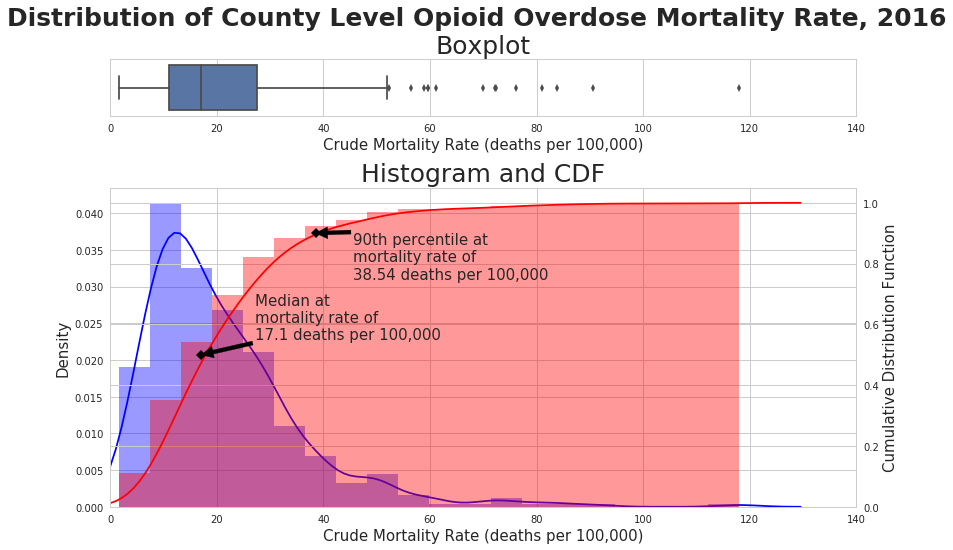

In [4]:
# Calculate number of bins to use for histogram
# Number of bins is the square root of number of data points: n_bins
n_data = len(merged_data['crude_opioid_mortality_rate'])
n_bins = np.sqrt(n_data)
# Convert number of bins to integer: n_bins
n_bins = int(n_bins)

# Cut the figure in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (12, 8))

# Add boxplot to first subplot
sns.boxplot(merged_data['crude_opioid_mortality_rate'], ax=ax_box)
# Set x-axis name for the boxplot
ax_box.set_xlabel('Crude Mortality Rate (deaths per 100,000)', fontsize = 15)
# Set x-axis range
ax_box.set_xlim((0, 140))
# Set number of tickmarks for x-axis
ax_box.xaxis.set_major_locator(plt.MaxNLocator(9))
# Set title for boxplot
ax_box.set_title("Boxplot", fontsize = 25)

# Add histogram to second subplot
sns.distplot(merged_data['crude_opioid_mortality_rate'], color = 'blue', bins = n_bins, ax=ax_hist)

# Have an overlaying plot for second subplot
ax_hist2 =ax_hist.twinx()

# Overlay ecdf to histogram
sns.distplot(merged_data['crude_opioid_mortality_rate'], 
             color = 'red', 
             bins= n_bins, 
             kde_kws = dict(cumulative = True), 
             hist_kws=dict(cumulative=True), 
             ax=ax_hist2)

# Calculate median for cdf
median = np.percentile(merged_data['crude_opioid_mortality_rate'], 50)
# Plot point at median
_ = plt.plot(median, .5, marker='D', color='black',
         linestyle='none')
# Add arrow at median with text
ax_hist2.annotate('Median at\nmortality rate of\n{} deaths per 100,000'.format(median), 
                  xy=(median, .5), 
                  xytext=(median + 10, 0.55),
                  arrowprops=dict(facecolor='black'),
                  fontsize = 15)

# Calculate 90th percentile for cdf
percentile_90th = np.percentile(merged_data['crude_opioid_mortality_rate'], 90)
# Plot point at 90th percentile
_ = plt.plot(percentile_90th, .9, marker='D', color='black',
         linestyle='none')
# Add arrow at 90th percentile with text
ax_hist2.annotate('90th percentile at\nmortality rate of\n{} deaths per 100,000'.format(round(percentile_90th, 2)), 
                  xy=(percentile_90th, .9), 
                  xytext=(percentile_90th + 7, 0.75),
                  arrowprops=dict(facecolor='black'),
                  fontsize = 15)

# Set x-axis limit for histogram
ax_hist.set_xlim((0, 140))

# Add axis labels for histogram and cdf
ax_hist.set_title("Histogram and CDF", fontsize = 25)
ax_hist.set_ylabel('Density', fontsize = 15)
ax_hist.set_xlabel('Crude Mortality Rate (deaths per 100,000)', fontsize = 15)
ax_hist2.set_ylabel('Cumulative Distribution Function', fontsize = 15)

# Add title to figure
f.suptitle('Distribution of County Level Opioid Overdose Mortality Rate, 2016', fontsize = 25, fontweight = 'bold')

# Adjust plot layout
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

We see that the county-level opioid overdose mortality rate has a long right tail. Based on the distribution of the crude mortality rate, we see that 90 percent of the counties have mortality rates in the range of 0 to 38.54 deaths per 100,000 people (0.04%).

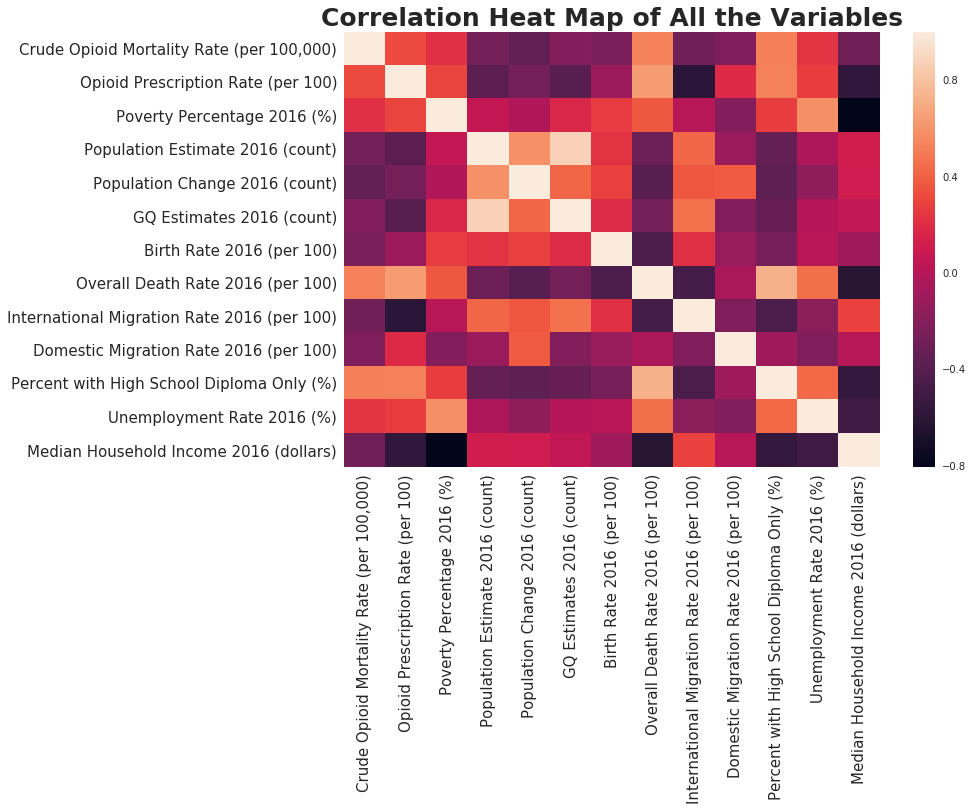

In [5]:
# remove fips_code, county, and state columns to prepare data for creating correlation matrix
merged_remove = merged_data.drop(labels = ['fips_code', 'county', 'state', 'fips_padded_zeros', 'county_state'], axis = 1)

# Create dictionary of variables and proper labels for display
merged_remove.columns = ['Crude Opioid Mortality Rate (per 100,000)', 
                                  'Opioid Prescription Rate (per 100)', 
                                  'Poverty Percentage 2016 (%)', 
                                  'Population Estimate 2016 (count)',
                                  'Population Change 2016 (count)',
                                  'GQ Estimates 2016 (count)',
                                  'Birth Rate 2016 (per 100)',
                                  'Overall Death Rate 2016 (per 100)',
                                  'International Migration Rate 2016 (per 100)',
                                  'Domestic Migration Rate 2016 (per 100)',
                                  'Percent with High School Diploma Only (%)',
                                  'Unemployment Rate 2016 (%)',
                                  'Median Household Income 2016 (dollars)']

plt.figure(figsize = (12, 8))
# correlation heatmap
sns.heatmap(merged_remove.corr())
# Set title
plt.title('Correlation Heat Map of All the Variables', fontsize = 25, fontweight = 'bold')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

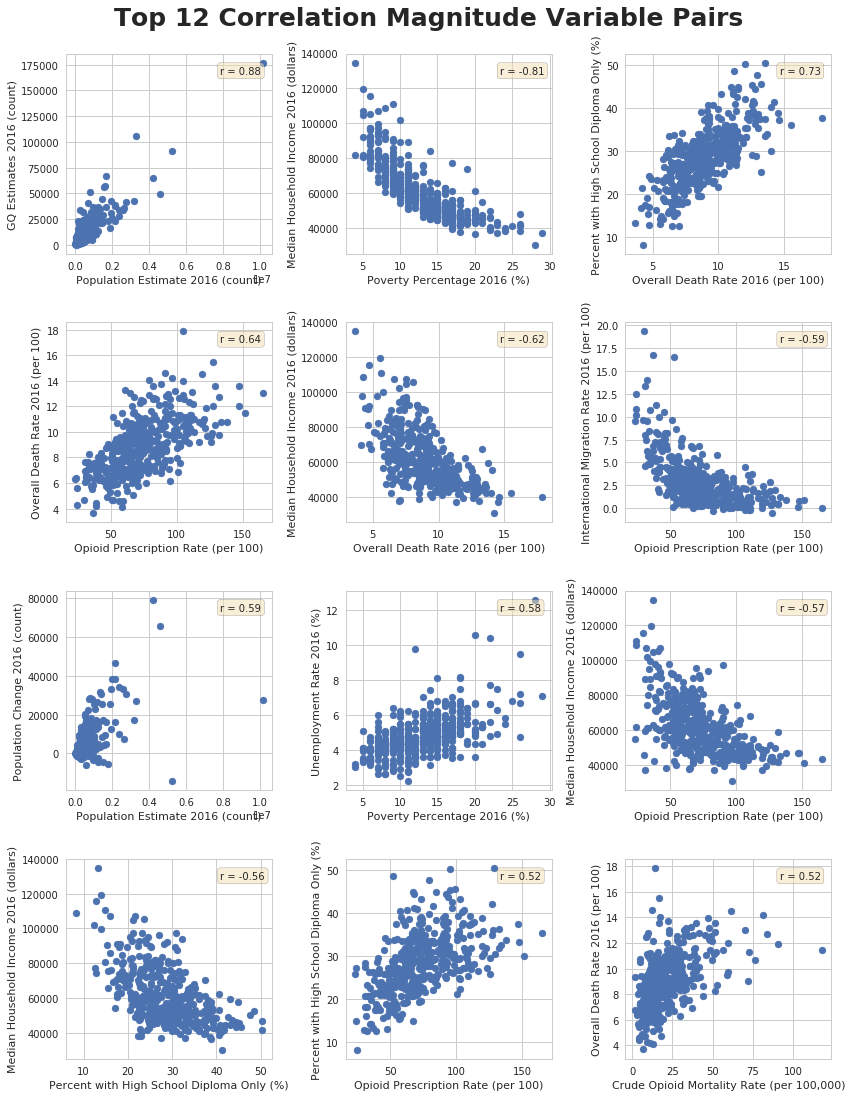

In [6]:
# flatten correlation matrix, select rows with corr < 1, calculate absolute value of correlation and sort by it, and display
# top ten correlation values
corr_flattened = merged_remove.corr().stack().drop_duplicates().reset_index()
corr_flattened.columns = ['variable_1', 'variable_2', 'correlation']
corr_flattened['abs_corr'] = corr_flattened.loc[corr_flattened.correlation < 1, 'correlation'].map(lambda x: abs(x))
corr_flattened_no_na = corr_flattened.dropna(how = 'any').sort_values('abs_corr', ascending = False).\
                       reset_index().drop('index', axis = 'columns')

plt.figure(figsize = (12, 16))
# plot scatter plot of the top twelve correlation magnitude variable pairs
for k in range(12):
    plt.subplot(4, 3, k + 1)
    plt.scatter(x = corr_flattened_no_na.variable_1[k], 
                y = corr_flattened_no_na.variable_2[k], data = merged_remove)
    plt.xlabel('{}'.format(corr_flattened_no_na.variable_1[k]))
    plt.ylabel('{}'.format(corr_flattened_no_na.variable_2[k]))
    plt.text(0.75, 0.9, 
             "r = " + str(round(corr_flattened_no_na.correlation[k], 2)), 
             transform=plt.gca().transAxes, 
             bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.suptitle("Top 12 Correlation Magnitude Variable Pairs", fontsize = 25, fontweight = 'bold')
plt.tight_layout(rect = [0, 0.03, 1, 0.97])
plt.show()

From the above correlation heat map and the data frame, we can see the variables that have high correlation values. Also, it's important to note that not all the relationships are linear.

Next, let's focus on correlation between crude mortality rate and all other variables.

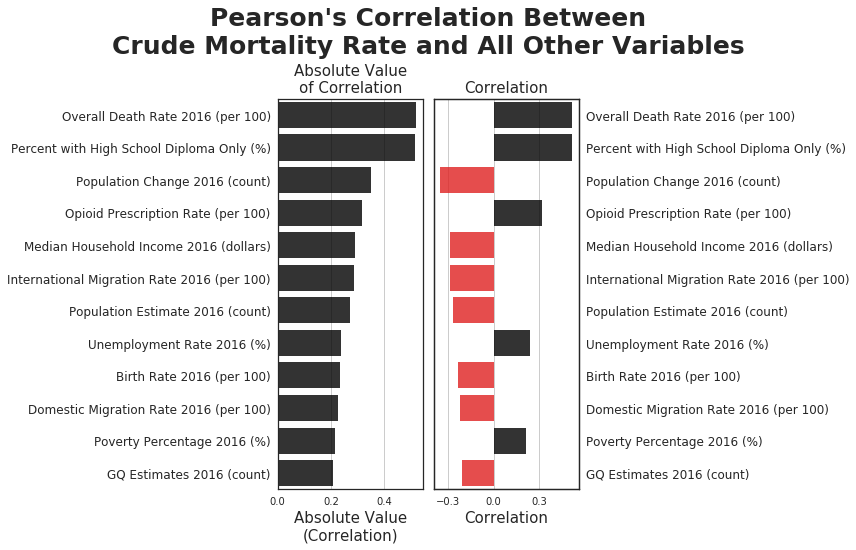

In [14]:
# calculate pairwise Pearson's correlation for all the variables
merged_corr = merged_remove.corr()

# drop crude_opioid_mortality_rate row from merged_corr and select only the column for crude_opioid_mortality_rate
crude_opioid_mortality_rate_corr = merged_corr.drop('Crude Opioid Mortality Rate (per 100,000)', axis = 0)\
                                   ['Crude Opioid Mortality Rate (per 100,000)']

# sorted correlations between crude_opioid_mortality_rate and all other variables
crude_corr_df = pd.DataFrame({
                              'p_corr' : crude_opioid_mortality_rate_corr,
                              'abs_corr': abs(crude_opioid_mortality_rate_corr),
                              'crude_opioid_mortality_rate_corr': crude_opioid_mortality_rate_corr 
                              }).sort_values('abs_corr', ascending = False).reset_index()
crude_corr_df.columns = ['variable', 'p_corr', 'abs_corr', 'crude_opioid_mortality_rate_corr']

# barplot of correlation values when calculating correlation with crude mortality rate

# add border
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25

# Cut the figure in 2 parts
f, (ax_abs_corr, ax_corr) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 8))

# First subplot
# Create barplot of absolute value correlation values
sns.barplot(x = 'abs_corr', y = 'variable', data = crude_corr_df, color = 'black', ax = ax_abs_corr, alpha = 0.8)
# Set labels
ax_abs_corr.set_title('Absolute Value\nof Correlation', fontsize = 15)
ax_abs_corr.set_xlabel('Absolute Value\n(Correlation)', fontsize = 15)
ax_abs_corr.set_ylabel("")
# Create new labels for variables

ax_abs_corr.set_yticklabels(labels = crude_corr_df.variable, fontsize = 12)

# Second subplot
# Set labels
ax_corr.set_xlabel('Correlation', fontsize = 15)
ax_corr.set_ylabel('')
ax_corr.set_yticklabels("")
# Turn off y-axis grid lines
ax_corr.grid(b = False, axis = 'y')
# Create another plot overlaying the second subplot
ax_corr2 =ax_corr.twinx()
# Assign colors red for negative correlation values, black for positive
clrs = ['red' if (x < 0) else 'black' for x in crude_corr_df.p_corr]
# Create bar plot of correlation values
sns.barplot(x = 'p_corr', y = 'variable', data = crude_corr_df, palette = clrs, ax = ax_corr2, alpha = 0.8)
# Add labels
ax_corr2.set_title('Correlation', fontsize = 15)
ax_corr2.set_xticks(ticks = [-0.3, 0, 0.3])
ax_corr2.set_ylabel("")
ax_corr2.set_yticklabels(labels = crude_corr_df.variable, fontsize = 12)

# Add main title for plot
plt.suptitle('Pearson\'s Correlation Between\nCrude Mortality Rate and All Other Variables', fontsize = 25, fontweight = 'bold')
plt.tight_layout(rect = [0, 0.03, 1, 0.9])
plt.show()

From above bar plot and dataframe, we can see that the top three variables most correlated with crude mortality rate are the death rate in the county per 1,000 people, percent of adults with a high school diploma only, and population change in 2016 for the county. Population change is negatively correlated with mortality rate due to opioid overdose.

### Scatter Plots

Let's see the scatter plots between crude mortality rate and the top nine variables that have high Pearson's correlation value.

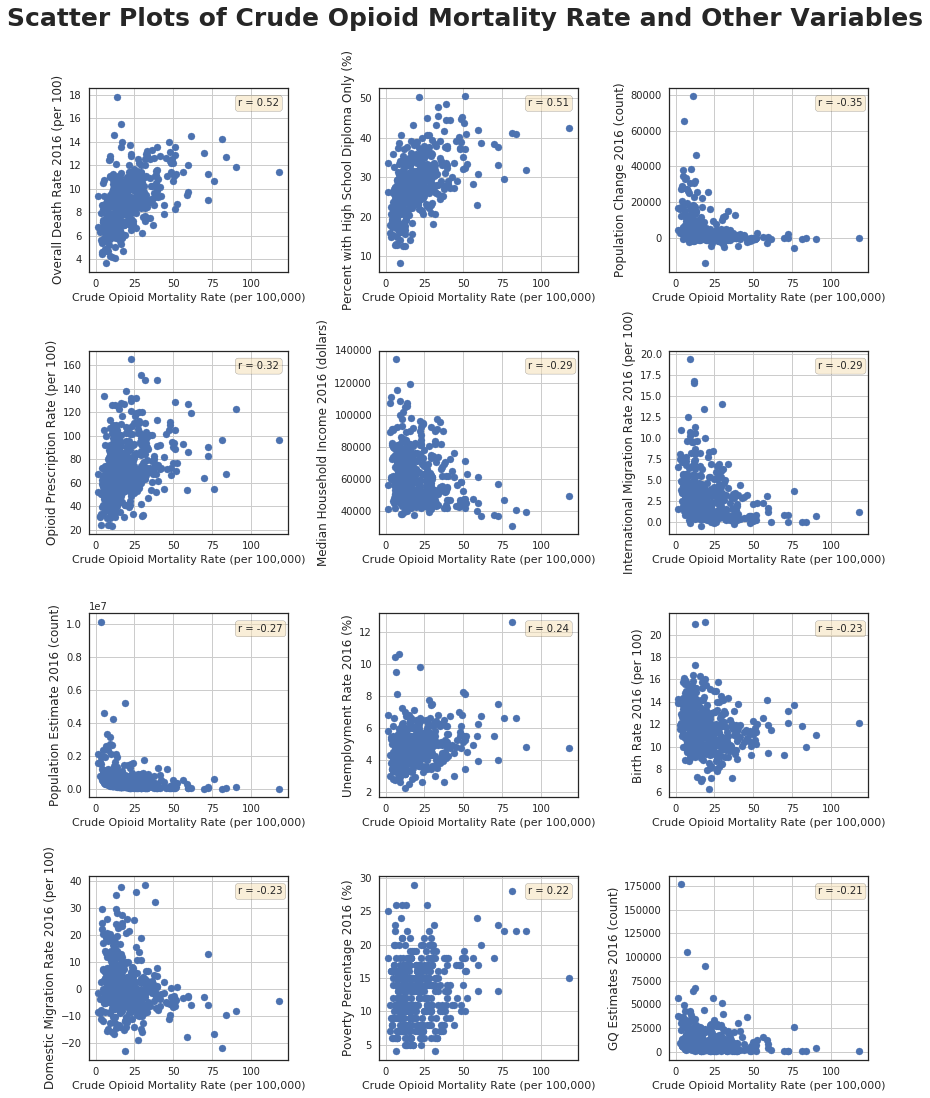

In [8]:
plt.figure(figsize = (12, 16))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.scatter(x = 'Crude Opioid Mortality Rate (per 100,000)', y = crude_corr_df.variable[i], data = merged_remove)
    plt.xlabel('Crude Opioid Mortality Rate (per 100,000)')
    plt.ylabel('{}'.format(crude_corr_df.variable[i]), fontsize = 12)
    plt.text(0.75, 0.9, 
             "r = " + str(round(crude_corr_df.crude_opioid_mortality_rate_corr[i], 2)), 
             transform=plt.gca().transAxes, 
             bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.suptitle("Scatter Plots of Crude Opioid Mortality Rate and Other Variables", fontsize = 25, fontweight = 'bold')
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

Here, we can see that not all the variables have a linear relationship with `Crude Opioid Mortality Rate`.

## Hypothesis Test of Correlation By Permuting Samples

We can see the observed correlation values between `Crude Opioid Mortality Rate (per 100,000)` and all the other continuous variables in the dataset. Could these correlation values be due to chance? Or are the correlation values statistically significant? To test this, let's run a hypothesis test of correlation by permuting samples for `Crude Opioid Mortality Rate (per 100,000)` and all other continuous variables.

Procedure:

1. Null hypothesis: `Crude Opioid Mortality Rate (per 100,000)` and one of the twelve continuous variable are completely uncorrelated. That is, $\rho = 0$.
* Alternative hypothesis: `Crude Opioid Mortality Rate (per 100,000)` and the other variables are correlated. That is, $\rho \neq 0$.
* Simulate the data assuming null hypothesis is true by permuting the `Crude Opioid Mortality Rate (per 100,000)` column 10000 times and calculating the correlation with the other variables. This will create 10000 permuted replicates of sample Pearson correlation $r$.
* Use sample Pearson correlation, $r$, as a test statistic.
* Compute p-value as fraction of permuted replicates that have $r$ more extreme than the observed $r$.
* Draw a conclusion based on significance level $\alpha = 0.01$.

In [9]:
# define a function to calculate Pearson correlation coefficient
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]
    
# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(shape = (10000, 12))

# Draw replicates
for i in range(10000):
    # Permute mortality rate measurments: mortality_rate_permuted
    mortality_rate_permuted = np.random.permutation(merged_remove['Crude Opioid Mortality Rate (per 100,000)'])

    for j in range(12):
        # Compute Pearson correlation between mortality rate and all 12 variables per permutation
        perm_replicates[i, j] = pearson_r(mortality_rate_permuted, merged_remove[crude_corr_df.variable[j]])

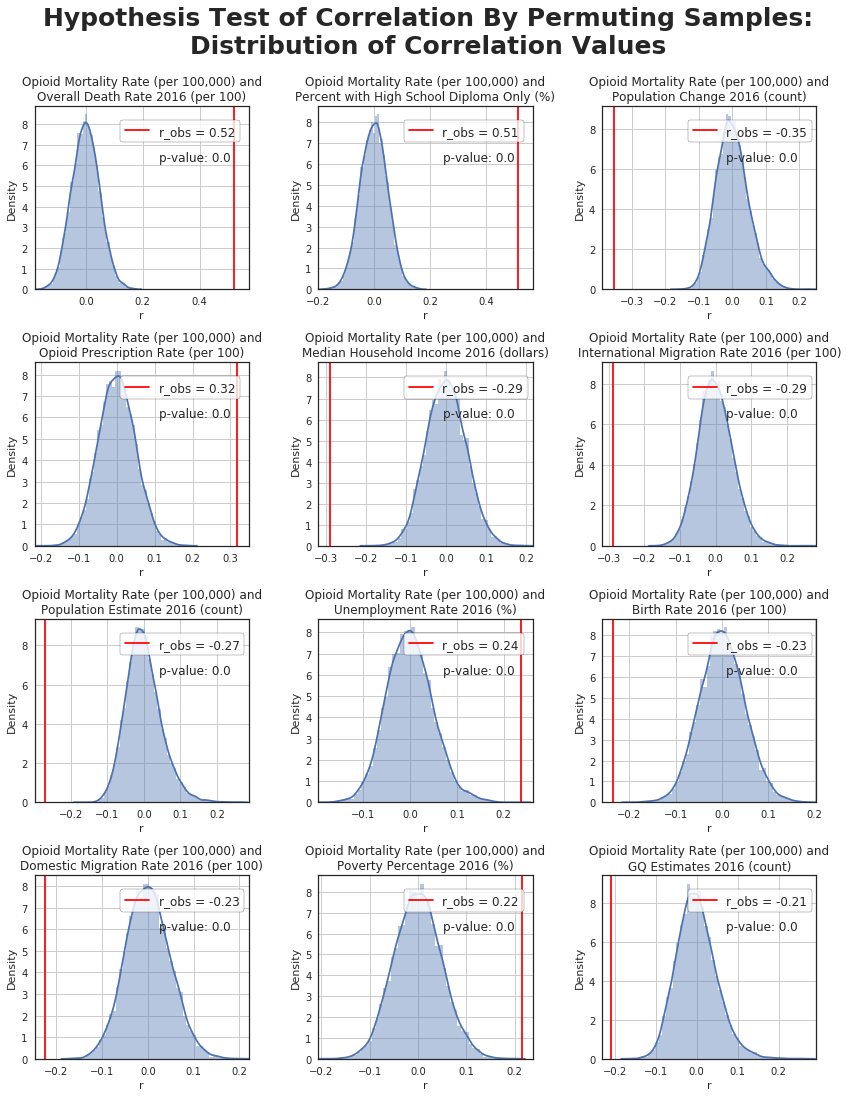

In [13]:
plt.figure(figsize = (12, 16))
# generate results of tests
for k in range(12):
    plt.subplot(4, 3, k + 1)
    r_obs = crude_corr_df.crude_opioid_mortality_rate_corr[k]
    # Compute p-value: p
    if r_obs > 0:
        p = np.sum(perm_replicates[:,k] >= r_obs) / len(perm_replicates[:,k])
    else:
        p = np.sum(perm_replicates[:,k] <= r_obs) / len(perm_replicates[:,k])

    # Generate a visual result of this correlation test
    _ = sns.distplot(perm_replicates[:,k], norm_hist = True)
    _ = plt.axvline(x=r_obs, color = 'red')
    _ = plt.title('Opioid Mortality Rate (per 100,000) and\n{}'.format(crude_corr_df.variable[k]))
    _ = plt.xlabel('r')
    _ = plt.ylabel('Density')
    _ = plt.xlim(min(min(perm_replicates[:,k]), r_obs) * 1.1, max(max(perm_replicates[:,k]), r_obs) * 1.1)
    leg = plt.legend(["r_obs = " + str(round(r_obs, 2))], bbox_to_anchor=(0, 0, 1, 1),
               loc = (0.4, 0.8), fontsize = 12, frameon = True)
    leg.get_frame().set_edgecolor('black')
    _ = plt.text(0.58, 0.7, 'p-value: {}'.format(round(p, 5)), transform=plt.gca().transAxes, fontsize = 12)
plt.suptitle('Hypothesis Test of Correlation By Permuting Samples:\nDistribution of Correlation Values', 
             fontsize = 25, fontweight = 'bold')
plt.tight_layout(rect = [0, 0.03, 1, 0.93])
plt.show()

From the results, we see that all the p-values are 0.0. Based on the significance level $\alpha = 0.01$, we reject the null hypothesis that the correlation values between `Crude Opioid Mortality Rate (per 100,000)` and all other continuous variables are zero. The correlation between `Crude Opioid Mortality Rate (per 100,000)` and all other continous variables are not due to random variation.

## Linear Regression and Confidence Interval Using Pairs Bootstrap

Let's examine the following pairs of variables to see how much one variable influences the other linearly:

* `GQ Estimates 2016 (count)` vs `Population Estimate 2016 (count)` (independent variable vs independent variable)
* `Percent with High School Diploma Only (%)` vs `Overall Death Rate 2016 (per 100)` (independent variable vs independent variable)
* `Overall Death Rate 2016 (per 100)` vs `Opioid Prescription Rate (per 100)` (independent variable vs independent variable)
* `Overall Death Rate 2016 (per 100)` vs `Crude Opioid Mortality Rate (per 100,000)` (independent variable vs dependent variable)
* `Percent with High School Diploma Only (%)` vs `Crude Opioid Mortality Rate (per 100,000)` (independent variable vs dependent variable)

To examine how much one variable influences the other lineary, let's construct a pairs bootstrap linear regression model and construct a 95% confidence interval on the slope. If the confidence interval does not contain zero, we will reject the null hypothesis that the slope is zero. Hence, there is a linear relationship between the two variables.

Since we are performing a pairs bootstrap, we do not need to make any assumptions about the distributions of the data except that the data is a representative sample of the population.

**Procedure**:
1. Null hypothesis is that the slope between the pairs of variables is zero in a linear regression model.
* Sample (x, y) pair of sample size n with replacement from the original sample of size n to obtain bootstrap sample of pairs of size n.
* Fit a linear regression model from the bootstrap sample of pairs in step 1 and calculate the slope and intercept.
* Repeat steps 1 and 2 $B$ times. Here, I will use $B = 1000$. This will create a bootstrap sampling distribution of the slopes and intercepts.
* Construct 95% bootstrap confidence interval using the bootstrap sampling distribution of the slopes.
* If the confidence interval from step 4 does not contain number 0, then reject the null hypothesis at $\alpha = 0.05$. Otherwise, do not reject the null hypothesis.

In [193]:
# define function to perform pairs bootstrap for linear regression
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

# pairs of variables
pair1 = ["GQ Estimates 2016 (count)", "Population Estimate 2016 (count)"]
pair2 = ["Percent with High School Diploma Only (%)", "Overall Death Rate 2016 (per 100)"]
pair3 = ["Overall Death Rate 2016 (per 100)", "Opioid Prescription Rate (per 100)"]
pair4 = ["Overall Death Rate 2016 (per 100)", "Crude Opioid Mortality Rate (per 100,000)"]
pair5 = ["Percent with High School Diploma Only (%)", "Crude Opioid Mortality Rate (per 100,000)"]

# list of the pairs of variables
pairs_of_variables = [pair1, pair2, pair3, pair4, pair5]
# length of the list pairs_of_variables
pairs_len = len(pairs_of_variables)

# create a list of empty lists for bootstrap slope and bootstrap confidence interval
bs_slope_reps = [[] for _ in range(pairs_len)]
bs_intercept_reps = [[] for _ in range(pairs_len)]
ci_95 = [[] for _ in range(pairs_len)]

for i in range(len(pairs_of_variables)):
    # Generate replicates of slope and intercept using pairs bootstrap
    bs_slope_reps[i], bs_intercept_reps[i] = draw_bs_pairs_linreg(merged_remove[pairs_of_variables[i][0]],\
                                                                          merged_remove[pairs_of_variables[i][1]], 1000)
    # Compute and print 95% CI for slope
    ci_95[i] = np.percentile(bs_slope_reps[i], [2.5, 97.5])

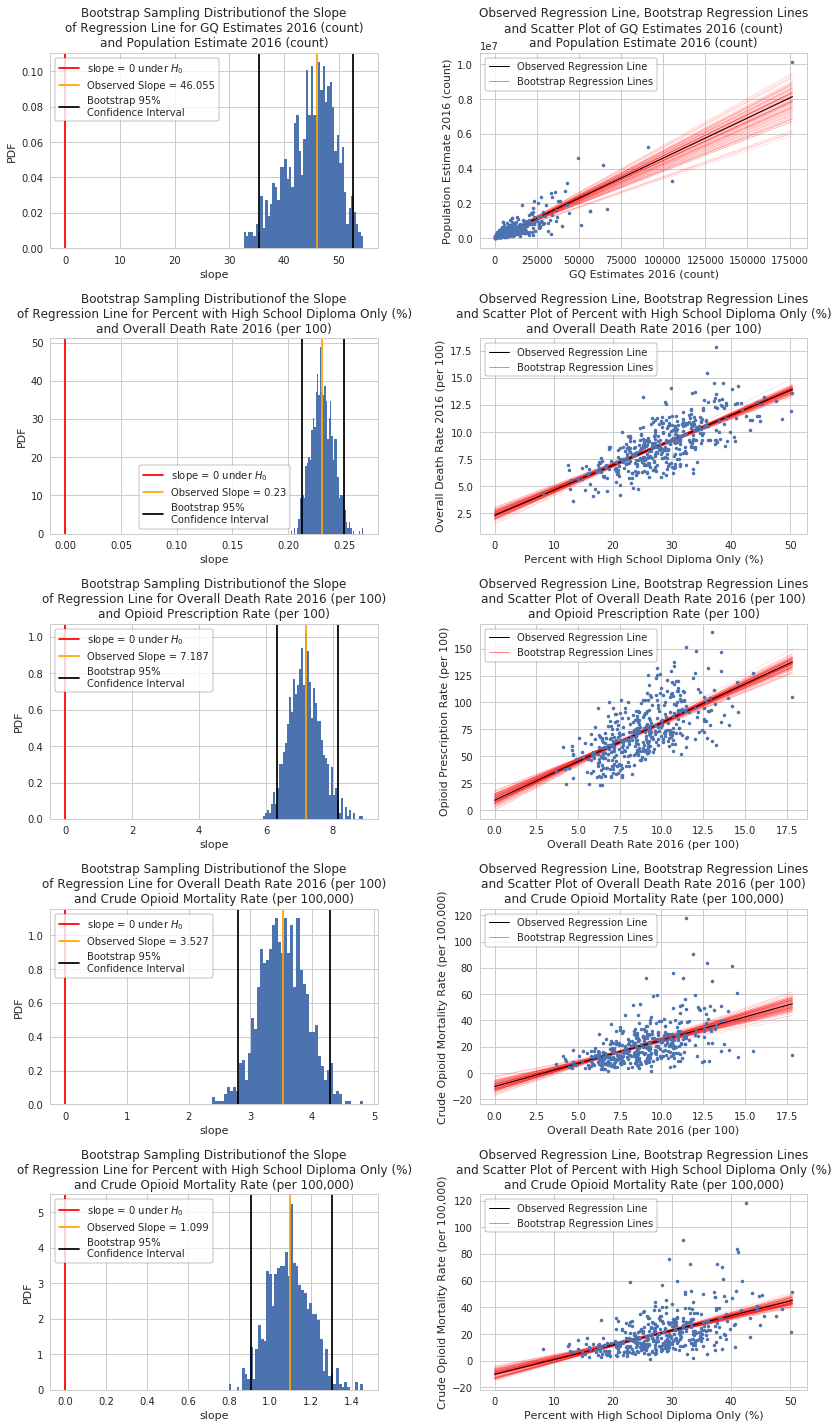

In [199]:
# create a figure with 5 rows and 2 columns
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (12, 20))

for i, ax in enumerate(axes):
    
    # observed regression line
    obs_slope, obs_intercept = np.polyfit(merged_remove[pairs_of_variables[i][0]],\
                                          merged_remove[pairs_of_variables[i][1]], 1)
    
    # Plot the histogram of bootstrap sampling distribution of slope
    _ = ax[0].hist(bs_slope_reps[i], bins=50, normed=True)
    _ = ax[0].set_xlabel('slope')
    _ = ax[0].set_ylabel('Density')
    _ = ax[0].set_title('Bootstrap Sampling Distributionof the Slope\nof Regression Line for {}\nand {}'\
                        .format(pairs_of_variables[i][0], pairs_of_variables[i][1]))
    # vertical line for null slope value
    _ = ax[0].axvline(x = 0, color = 'red', label = r"slope = 0 under $H_0$")
    # vertical line for observed slope value
    _ = ax[0].axvline(x = obs_slope, color = 'orange', label = "Observed Slope = {}".format(round(obs_slope, 3)))
    # vertical line for confidence interval
    _ = ax[0].axvline(x = ci_95[i][0], color = 'black', label = 'Bootstrap 95%\nConfidence Interval')
    _ = ax[0].axvline(x = ci_95[i][1], color = 'black')
    
    # create legend for histogram
    leg1 = ax[0].legend(frameon = True)
    leg1.get_frame().set_edgecolor('black')
           
    # Generate array of x-values for bootstrap lines: x
    x = np.array([0, max(merged_remove[pairs_of_variables[i][0]])])

    # Plot the bootstrap lines
    # first bootstrap line is used for legend
    bootstrap_regr, = ax[1].plot(x, bs_slope_reps[i][0]*x + bs_intercept_reps[i][0],
                     linewidth=0.5, alpha=0.2, color='red', label = 'Bootstrap Regression Lines')
    # the rest of the bootstrap lines
    for j in range(1, 100):
        _ = ax[1].plot(x, bs_slope_reps[i][j]*x + bs_intercept_reps[i][j],
                     linewidth=0.5, alpha=0.2, color='red')

    # plot of observed regression line
    obs_regr, = ax[1].plot(x, obs_slope * x + obs_intercept, linewidth = 1, color = 'black', label = 'Observed Regression Line')

    # create legend for plot
    leg2 = ax[1].legend(handles = [obs_regr, bootstrap_regr], frameon = True)
    leg2.get_frame().set_edgecolor('black')
    for l in leg2.get_lines():
        l.set_alpha(1)
        
    # Plot scatter plot
    _ = ax[1].plot(merged_remove[pairs_of_variables[i][0]],\
                 merged_remove[pairs_of_variables[i][1]],\
                 marker = '.', linestyle = 'none')

    # Label axes
    _ = ax[1].set_xlabel(pairs_of_variables[i][0])
    _ = ax[1].set_ylabel(pairs_of_variables[i][1])
    _ = ax[1].set_title('Observed Regression Line, Bootstrap Regression Lines\nand Scatter Plot of {}\nand {}'\
                        .format(pairs_of_variables[i][0], pairs_of_variables[i][1]))
# show the plot
fig.tight_layout()
fig.show()

From the bootstrap confidence intervals of the slope, we can see that the slopes between the variables are not zero. So, at 95% significance level, we reject the null hypothesis that the slope is zero for these five pairs of variables.

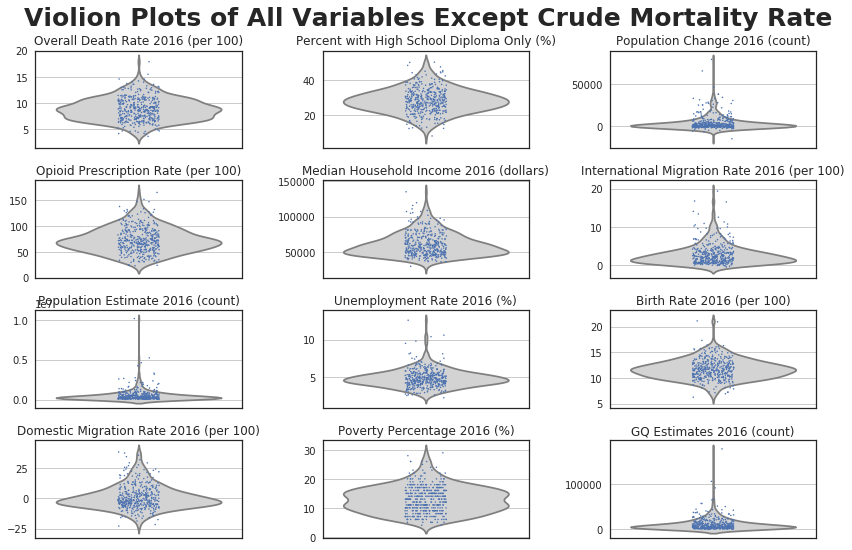

In [11]:
plt.figure(figsize = (12, 8))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    sns.violinplot(y = crude_corr_df.variable[i], data = merged_remove, inner = None, color = 'lightgray')
    sns.stripplot(y = crude_corr_df.variable[i], data = merged_remove, size = 1.5, jitter = True)
    plt.ylabel('')
    plt.title('{}'.format(crude_corr_df.variable[i]))
plt.suptitle('Violion Plots of All Variables Except Crude Mortality Rate', fontsize = 25, fontweight = 'bold')
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

From these violin plots, I see that most of the variables have distributions that are right skewed (long right tail).

## Conclusion From Exploratory Data Analysis

It seems as if the the counties with higher mortality rates caused by opioid addiction have the following:
* Higher overall mortality rate
* Have more adults with high school diplomas only
* Higher opioid prescription rates
* Decrease in population size in 2016
* Lower median household income  

The reason why counties with higher mortality rate caused by opioid overdose tend to come from counties with higher overall mortality rate should be investigated further. One reason that these counties have such high mortality rates could be that the population in these counties are older. Another reason could be that these counties may not have good access to healthcare for the residents. This can be something on which we can do more research.

Further research could also be done to investigate as to why counties that have high percentage of the population with only high school diplomas have high opioid overdose mortality rate. This can be because the population in these counties are older. Or, people in these counties may not have access to higher education for some reason.